In [1]:
import numpy as np
import tensorflow as tf
import random
import datetime

from tensorflow.python.keras.optimizer_v2 import gradient_descent
from tensorflow.keras import layers

import matplotlib.pyplot as plt

# Data Preparation

In [9]:
# Download cifar10 data
cifar_train, cifar_test = tf.keras.datasets.cifar10.load_data()
cifar_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[(x.dtype, x.shape) for x in cifar_train]

[(dtype('uint8'), (50000, 32, 32, 3)), (dtype('uint8'), (50000, 1))]

In [10]:
CLIENTS = 3
SIZE = 5000

def get_data(source):   
    
    #idx = np.random.choice(len(source[1]), amount*SHARES, replace=False)
    
    all_data = (np.array(source[0][:SIZE*CLIENTS] / 255, dtype=np.float32), 
                tf.keras.utils.to_categorical(source[1][:SIZE*CLIENTS])) 
    
    split_data = []
    for s in range(CLIENTS):
        start = s*SIZE
        end = s*SIZE + SIZE
        split_data.append((all_data[0][start:end], all_data[1][start:end]))
    
    external_data = (np.array(source[0][SIZE*CLIENTS:] / 255, dtype=np.float32), 
                tf.keras.utils.to_categorical(source[1][SIZE*CLIENTS:])) 
    
    return all_data, split_data, external_data

In [11]:
cifar_test_data = (np.array(cifar_test[0] / 255, dtype=np.float32), 
                tf.keras.utils.to_categorical(cifar_test[1]))

cifar_train_data, cifar_train_fed_data, attacker_data = get_data(cifar_train)

# retina_test_data, retina_test_fed_data = get_data(retina_test, 3000)
# retina_train_data, retina_train_fed_data = get_data(retina_train, 9000)

In [12]:
cifar_train_fed_data[1][1].shape

(5000, 10)

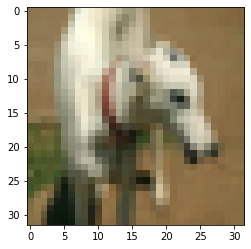

In [7]:
from matplotlib import pyplot as plt

plt.imshow(cifar_train_fed_data[2][0][-4])
plt.grid(False)
plt.show()

# FL from scratch

# Creating a model with Keras

In [13]:
WIDTH = 32
HEIGHT = 32
CHANNELS = 3


def create_compiled_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32,(5, 5),
            activation="relu",
            padding="same",
            input_shape=(WIDTH, HEIGHT, CHANNELS)),
        #tf.keras.layers.Conv2D(32,(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        #tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (5, 5), activation="relu", padding="same"),
        #tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        #tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(), 
        tf.keras.layers.Dense(512, activation="relu"),
        #tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    
#     def loss_fn(y_true, y_pred):
#         return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
#         y_true, y_pred))
    
    
    model.compile(
      loss=tf.keras.losses.categorical_crossentropy,
      optimizer="adam",
      metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return model

# Non-federated keras model

In [14]:
centralized_model = create_compiled_keras_model()
history_callback = centralized_model.fit(cifar_train_data[0], cifar_train_data[1], validation_data=cifar_test_data, batch_size=32, epochs=36)

Train on 15000 samples, validate on 10000 samples
Epoch 1/36
15000/15000 [==============================] - 41s 3ms/sample - loss: 1.6504 - categorical_accuracy: 0.4033 - val_loss: 1.3980 - val_categorical_accuracy: 0.4984
Epoch 2/36
15000/15000 [==============================] - 40s 3ms/sample - loss: 1.2671 - categorical_accuracy: 0.5487 - val_loss: 1.2085 - val_categorical_accuracy: 0.5669
Epoch 3/36
15000/15000 [==============================] - 38s 3ms/sample - loss: 1.0512 - categorical_accuracy: 0.6215 - val_loss: 1.2016 - val_categorical_accuracy: 0.5791
Epoch 4/36
15000/15000 [==============================] - 40s 3ms/sample - loss: 0.8741 - categorical_accuracy: 0.6917 - val_loss: 1.1115 - val_categorical_accuracy: 0.6254
Epoch 5/36
15000/15000 [==============================] - 37s 2ms/sample - loss: 0.6821 - categorical_accuracy: 0.7599 - val_loss: 1.1041 - val_categorical_accuracy: 0.6338
Epoch 6/36
15000/15000 [==============================] - 37s 2ms/sample - loss: 0.49

In [15]:
centralized_model.save("models/centralized.h5")

In [16]:
import datetime

try:
    with open('Logs/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar, Centralized, IDD, minibatch_size: 32", file=log)
        print("NFTrain = {}".format(history_callback.history["loss"]), file=log)
        print("NFTest = {}".format(history_callback.history["val_loss"]), file=log)
        print("NFAccuracy = {}".format(history_callback.history["val_categorical_accuracy"]), file=log)
                
except IOError:
    print('File Error')

# Single Models

In [17]:
single_model0 = create_compiled_keras_model()
history_callback0 = single_model0.fit(cifar_train_fed_data[0][0], cifar_train_fed_data[0][1], validation_data=cifar_test_data, batch_size=32, epochs=36)
single_model0.save('models/ind0.h5')

Train on 5000 samples, validate on 10000 samples
Epoch 1/36
5000/5000 [==============================] - 15s 3ms/sample - loss: 1.9542 - categorical_accuracy: 0.2820 - val_loss: 1.7007 - val_categorical_accuracy: 0.3844
Epoch 2/36
5000/5000 [==============================] - 15s 3ms/sample - loss: 1.5230 - categorical_accuracy: 0.4450 - val_loss: 1.4461 - val_categorical_accuracy: 0.4714
Epoch 3/36
5000/5000 [==============================] - 15s 3ms/sample - loss: 1.3119 - categorical_accuracy: 0.5244 - val_loss: 1.4194 - val_categorical_accuracy: 0.4817
Epoch 4/36
5000/5000 [==============================] - 15s 3ms/sample - loss: 1.1518 - categorical_accuracy: 0.5800 - val_loss: 1.4005 - val_categorical_accuracy: 0.5119
Epoch 5/36
5000/5000 [==============================] - 14s 3ms/sample - loss: 0.9430 - categorical_accuracy: 0.6670 - val_loss: 1.5534 - val_categorical_accuracy: 0.4974
Epoch 6/36
5000/5000 [==============================] - 15s 3ms/sample - loss: 0.7536 - categori

In [18]:
single_model1 = create_compiled_keras_model()
history_callback1 = single_model1.fit(cifar_train_fed_data[1][0], cifar_train_fed_data[1][1], validation_data=cifar_test_data, batch_size=32, epochs=36)
single_model1.save('models/ind1.h5')

Train on 5000 samples, validate on 10000 samples
Epoch 1/36
5000/5000 [==============================] - 14s 3ms/sample - loss: 2.0256 - categorical_accuracy: 0.2418 - val_loss: 1.7465 - val_categorical_accuracy: 0.3599
Epoch 2/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 1.6114 - categorical_accuracy: 0.4114 - val_loss: 1.6765 - val_categorical_accuracy: 0.4082
Epoch 3/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 1.4085 - categorical_accuracy: 0.4914 - val_loss: 1.4323 - val_categorical_accuracy: 0.4859
Epoch 4/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 1.2058 - categorical_accuracy: 0.5690 - val_loss: 1.4569 - val_categorical_accuracy: 0.4911
Epoch 5/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 1.0626 - categorical_accuracy: 0.6194 - val_loss: 1.4098 - val_categorical_accuracy: 0.5073
Epoch 6/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 0.8889 - categori

In [19]:
single_model2 = create_compiled_keras_model()
history_callback2 = single_model2.fit(cifar_train_fed_data[2][0], cifar_train_fed_data[2][1], validation_data=cifar_test_data, batch_size=32, epochs=36)
single_model2.save('models/ind2.h5')

Train on 5000 samples, validate on 10000 samples
Epoch 1/36
5000/5000 [==============================] - 14s 3ms/sample - loss: 1.9030 - categorical_accuracy: 0.3006 - val_loss: 1.6718 - val_categorical_accuracy: 0.3894
Epoch 2/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 1.5808 - categorical_accuracy: 0.4212 - val_loss: 1.4990 - val_categorical_accuracy: 0.4661
Epoch 3/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 1.3553 - categorical_accuracy: 0.5126 - val_loss: 1.3616 - val_categorical_accuracy: 0.5092
Epoch 4/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 1.1615 - categorical_accuracy: 0.5838 - val_loss: 1.3955 - val_categorical_accuracy: 0.5006
Epoch 5/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 0.9671 - categorical_accuracy: 0.6588 - val_loss: 1.3753 - val_categorical_accuracy: 0.5202
Epoch 6/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 0.7888 - categori

In [20]:
try:
    with open('Logs/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar10, Single party 0, IDD, minibatch_size: 32", file=log)
        print("Ind0Train = {}".format(history_callback0.history["loss"]), file=log)
        print("Ind0Test = {}".format(history_callback0.history["val_loss"]), file=log)
        print("Ind0Accuracy = {}".format(history_callback0.history["val_categorical_accuracy"]), file=log)
                
except IOError:
    print('File Error')

In [49]:
SingAvTrain = (np.array(history_callback0.history["loss"]) 
 + np.array(history_callback1.history["loss"]) 
 + np.array(history_callback2.history["loss"])) / 3
SingAvTest = (np.array(history_callback0.history["val_loss"]) 
 + np.array(history_callback1.history["val_loss"]) 
 + np.array(history_callback2.history["val_loss"])) / 3
SingAvAcc = (np.array(history_callback0.history["val_categorical_accuracy"]) 
 + np.array(history_callback1.history["val_categorical_accuracy"]) 
 + np.array(history_callback2.history["val_categorical_accuracy"])) / 3

In [50]:
try:
    with open('Logs/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar10, SingleAverage, IDD, minibatch_size: 32", file=log)
        print("SingAvTrain = {}".format(SingAvTrain), file=log)
        print("SingAvTest = {}".format(SingAvTest), file=log)
        print("SingAvAcc = {}".format(SingAvAcc), file=log)
                
except IOError:
    print('File Error')

# Models Ensemble


In [56]:
probabilities0 = single_model0.predict_proba(cifar_test_data[0], batch_size=32, verbose=1)

5000/5000 [==============================] - 2s 483us/sample


In [57]:
probabilities1 = single_model1.predict_proba(cifar_test_data[0], batch_size=32, verbose=1)

5000/5000 [==============================] - 2s 426us/sample


In [58]:
probabilities2 = single_model2.predict_proba(cifar_test_data[0], batch_size=32, verbose=1)

5000/5000 [==============================] - 3s 622us/sample


In [59]:
probs = (probabilities0 + probabilities1 + probabilities2) / 3

In [55]:
losses = tf.keras.losses.categorical_crossentropy(cifar_train_data[1], probs, from_logits=False)
print(np.mean(losses.numpy()))

0.47005984


In [60]:
val_loss = tf.keras.losses.categorical_crossentropy(cifar_test_data[1], probs, from_logits=False)
print(np.mean(val_loss.numpy()))

1.785349


In [61]:
from sklearn.metrics import accuracy_score

y_pred = probs.argmax(axis=1)
y_true = cifar_test_data[1].argmax(axis=1)

accuracy_score(y_true, y_pred)

0.6052

In [1060]:
target_model.evaluate(target_data[0], target_data[1])
target_model.evaluate(external_data[0], external_data[1])

3000/3000 [==============================] - 2s 639us/sample - loss: 1.1781 - categorical_accuracy: 0.6413


[1.1781345659891764, 0.64133334]

# Cyclic Weight Transfer

In [21]:
cyc_transfer_model = create_compiled_keras_model()
CycTrTrain = []
CycTrTest = []
CycTrAcc = []

for r in range(6):
    for c in range(CLIENTS):
        history_callback = cyc_transfer_model.fit(cifar_train_fed_data[c][0], cifar_train_fed_data[c][1], 
                                                     validation_data=cifar_test_data, batch_size=32, epochs=2)
        CycTrTrain.append(history_callback.history['loss'])
        CycTrTest.append(history_callback.history['val_loss'])
        CycTrAcc.append(history_callback.history['val_categorical_accuracy'])

Train on 5000 samples, validate on 10000 samples
Epoch 1/2
5000/5000 [==============================] - 20s 4ms/sample - loss: 1.9143 - categorical_accuracy: 0.2988 - val_loss: 1.8399 - val_categorical_accuracy: 0.3320
Epoch 2/2
5000/5000 [==============================] - 20s 4ms/sample - loss: 1.5754 - categorical_accuracy: 0.4304 - val_loss: 1.5265 - val_categorical_accuracy: 0.4442
Train on 5000 samples, validate on 10000 samples
Epoch 1/2
5000/5000 [==============================] - 18s 4ms/sample - loss: 1.4955 - categorical_accuracy: 0.4640 - val_loss: 1.4732 - val_categorical_accuracy: 0.4655
Epoch 2/2
5000/5000 [==============================] - 19s 4ms/sample - loss: 1.2837 - categorical_accuracy: 0.5402 - val_loss: 1.3521 - val_categorical_accuracy: 0.5272
Train on 5000 samples, validate on 10000 samples
Epoch 1/2
5000/5000 [==============================] - 24s 5ms/sample - loss: 1.3697 - categorical_accuracy: 0.5116 - val_loss: 1.2907 - val_categorical_accuracy: 0.5392
Epo

In [22]:
cyc_transfer_model.save("models/weight_transfer.h5")

In [23]:
try:
    with open('Logs/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar10, Cyclic Weight Transfer, IDD, minibatch_size: 32", file=log)
        print("CycTrTrain = {}".format(CycTrTrain), file=log)
        print("CyctTrTest = {}".format(CycTrTest), file=log)
        print("CycTrAccuracy = {}".format(CycTrAcc), file=log)
                
except IOError:
    print('File Error')

# Federated Learning

In [ ]:
initial_model = create_compiled_keras_model()

FedTrain = []
FedTest = []
FedAcc = []

for r in range(36):
    
    deltas = []

    for c in range(CLIENTS):

        federated_model = create_compiled_keras_model()

        federated_model.set_weights(initial_model.get_weights())

        history_callback = federated_model.fit(cifar_train_fed_data[c][0], cifar_train_fed_data[c][1], 
                                               batch_size=32, epochs=1, verbose=0)

        
        delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

        deltas.append(delta)
    print('Epoch {}/18'.format(r+1))
    delt_av = (deltas[0] + deltas[1] + deltas[2]) / 3
    new_weights = np.array(initial_model.get_weights()) - delt_av
    initial_model.set_weights(new_weights)
    
    FedTrain.append(initial_model.evaluate(cifar_train_data[0], cifar_train_data[1])[0])
    validation = initial_model.evaluate(cifar_test_data[0], cifar_test_data[1])
    FedTest.append(validation[0])
    FedAcc.append(validation[1])

Epoch 1/18
10000/10000 [==============================] - 7s 703us/sample - loss: 1.9095 - categorical_accuracy: 0.3568
Epoch 2/18
10000/10000 [==============================] - 9s 879us/sample - loss: 1.4220 - categorical_accuracy: 0.4875
Epoch 3/18
10000/10000 [==============================] - 8s 811us/sample - loss: 1.3366 - categorical_accuracy: 0.5230
Epoch 4/18
10000/10000 [==============================] - 11s 1ms/sample - loss: 1.2430 - categorical_accuracy: 0.5628
Epoch 5/18
10000/10000 [==============================] - 7s 708us/sample - loss: 1.1804 - categorical_accuracy: 0.5792
Epoch 6/18
10000/10000 [==============================] - 8s 808us/sample - loss: 1.1296 - categorical_accuracy: 0.5967
Epoch 7/18
10000/10000 [==============================] - 7s 683us/sample - loss: 1.1131 - categorical_accuracy: 0.6096
Epoch 8/18
10000/10000 [==============================] - 6s 585us/sample - loss: 1.0697 - categorical_accuracy: 0.6263
Epoch 9/18
10000/10000 [=================

In [ ]:
federated_model.save("models/fedE1B32.h5")

In [ ]:
try:
    with open('Logs/'+ datetime.datetime.now().strftime("%y-%m-%d-%H-%M")+'.txt', 'w') as log:
        print("Cifar10, Federated Model, IDD, minibatch_size: 32", file=log)
        print("FedTrainE1B32 = {}".format(FedTrain), file=log)
        print("FedTestE1B32 = {}".format(FedTest), file=log)
        print("FedAccuracyE1B32 = {}".format(FedAcc), file=log)
                
except IOError:
    print('File Error')

# Membership Inference Attack (MIA)

In [94]:
import numpy as np
from numpy.random import seed

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data

## Outsider Attack

In [308]:
from sklearn.ensemble import AdaBoostClassifier

def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.

    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    
    model = AdaBoostClassifier(n_estimators=250, random_state=0)
    return model

In [96]:
# training a shadow model with external data
shadow_model = create_compiled_keras_model()
history_callback = shadow_model.fit(attacker_data[0], attacker_data[1], validation_data=external_data, batch_size=32, epochs=36)

Train on 5000 samples, validate on 5000 samples
Epoch 1/36
5000/5000 [==============================] - 17s 3ms/sample - loss: 1.8887 - categorical_accuracy: 0.3086 - val_loss: 1.7002 - val_categorical_accuracy: 0.3774
Epoch 2/36
5000/5000 [==============================] - 12s 2ms/sample - loss: 1.5297 - categorical_accuracy: 0.4564 - val_loss: 1.5473 - val_categorical_accuracy: 0.4482
Epoch 3/36
5000/5000 [==============================] - 11s 2ms/sample - loss: 1.3551 - categorical_accuracy: 0.5150 - val_loss: 1.4526 - val_categorical_accuracy: 0.4782
Epoch 4/36
5000/5000 [==============================] - 11s 2ms/sample - loss: 1.1784 - categorical_accuracy: 0.5808 - val_loss: 1.3858 - val_categorical_accuracy: 0.5060
Epoch 5/36
5000/5000 [==============================] - 12s 2ms/sample - loss: 0.9826 - categorical_accuracy: 0.6508 - val_loss: 1.3590 - val_categorical_accuracy: 0.5230
Epoch 6/36
5000/5000 [==============================] - 13s 3ms/sample - loss: 0.8365 - categoric

In [97]:
shadow_model.save('models/shadow_model.h5')

In [347]:
target_data = cifar_train_fed_data[0]
target_model = tf.keras.models.load_model('models/fedE1B32.h5')

In [348]:
NUM_CLASSES = 10

# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)


in_preds = shadow_model.predict_proba(attacker_data)
out_preds = shadow_model.predict_proba(external_data)

        
X_shadow = np.concatenate((np.concatenate((in_preds, out_preds), axis=0), 
                           np.concatenate((attacker_data[1], external_data[1]), axis=0)), 
                          axis=1)
    
y_shadow = np.concatenate((np.ones(SIZE), np.zeros(SIZE)), axis=0)

# Fit the attack models.
print("Training the attack models...")
amb.fit(X_shadow, y_shadow)

Training the attack models...


In [306]:
# from sklearn.model_selection import cross_val_score
# amb = AdaBoostClassifier(n_estimators=250)
# scores = cross_val_score(amb, X_shadow, y_shadow)
# scores

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.79694061, 0.80233953, 0.79321729])

In [349]:
# Compile them into the expected format for the AttackModelBundle.
attack_test_data, real_membership_labels = prepare_attack_data(
    target_model, target_data, cifar_test_data)


# Compute the attack accuracy.
attack_guesses = amb.predict(attack_test_data)
attack_precision = np.mean((attack_guesses == 1) == (real_membership_labels == 1))

class_precision = []

for c in range(NUM_CLASSES):
    target_indices = [i for i, d in enumerate(target_data[1].argmax(axis=1)) if d == c]
    test_indices = [i for i, d in enumerate(cifar_test_data[1].argmax(axis=1)) if d == c]


    print(np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                 + np.sum(attack_guesses[SIZE:][test_indices])))

    class_precision.append(
        np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                 + np.sum(attack_guesses[SIZE:][test_indices])))

print('Average precision: ', attack_precision)

0.6521739130434783
0.5765550239234449
0.6944444444444444
0.7829787234042553
0.6919540229885057
0.7123287671232876
0.650887573964497
0.595360824742268
0.5928571428571429
0.6239460370994941
Average precision:  0.6184


In [133]:
try:
    with open('Logs/MIA_outsider_E3B64.txt', 'w') as log:
        print("fedE3B64.h5 = {}".format(class_precision), file=log)
        #print("average_precision = {}".format(attack_precision), file=log)

except IOError:
    print('File Error')

## Insider Attacks

In [355]:
target_data = cifar_train_fed_data[0]
insider_attack_data = cifar_train_fed_data[2]

target_model = tf.keras.models.load_model('models/fedE3B64.h5')

In [356]:
in_preds = target_model.predict_proba(insider_attack_data)
out_preds = target_model.predict_proba(external_data)

In [357]:
X_shadow = np.concatenate((np.concatenate((in_preds, out_preds), axis=0), 
                           np.concatenate((insider_attack_data[1], external_data[1]), axis=0)), axis=1)
    
y_shadow = np.concatenate((np.ones(15000), np.zeros(SIZE)), axis=0)

In [358]:
def attack_model_fn():
    model = AdaBoostClassifier(n_estimators=250, random_state=0)  
    return model

amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)
amb.fit(X_shadow, y_shadow)
attack_test_data, real_membership_labels = prepare_attack_data(target_model, 
                                                               target_data, cifar_test_data)

ValueError: too many values to unpack (expected 2)

In [354]:
attack_guesses = amb.predict(attack_test_data)
attack_precision = np.mean((attack_guesses == 1) == (real_membership_labels == 1))

class_precision = []

for c in range(NUM_CLASSES):
    target_indices = [i for i, d in enumerate(target_data[1].argmax(axis=1)) if d == c]
    test_indices = [i for i, d in enumerate(cifar_test_data[1].argmax(axis=1)) if d == c]


    print(np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                 + np.sum(attack_guesses[SIZE:][test_indices])))
    class_precision.append(
            np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                     + np.sum(attack_guesses[SIZE:][test_indices])))
print("Average precision: ", attack_precision)

0.6287878787878788
0.5555555555555556
0.6758620689655173
0.6794871794871795
0.6658767772511849
0.6413502109704642
0.5882352941176471
0.5742049469964664
0.5684931506849316
0.5911179173047473
Average precision:  0.6152


In [178]:
try:
    with open('Logs/MIA_in_E3B64.txt', 'w') as log:
        print("insider_E3B64 = {}".format(class_precision), file=log)
                
except IOError:
    print('File Error')

# Original MIA Attack

In [179]:
"""
Example membership inference attack against a deep net classifier on the CIFAR10 dataset
"""
import numpy as np

from absl import app
from absl import flags

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data


NUM_CLASSES = 10
WIDTH = 32
HEIGHT = 32
CHANNELS = 3
SHADOW_DATASET_SIZE = 4000
ATTACK_TEST_DATASET_SIZE = 4000


FLAGS = flags.FLAGS
flags.DEFINE_integer(
    "target_epochs", 12, "Number of epochs to train target and shadow models."
)
flags.DEFINE_integer("attack_epochs", 12, "Number of epochs to train attack models.")
flags.DEFINE_integer("num_shadows", 3, "Number of epochs to train attack models.")


# def get_data():
#     """Prepare CIFAR10 data."""
#     (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
#     y_train = tf.keras.utils.to_categorical(y_train)
#     y_test = tf.keras.utils.to_categorical(y_test)
#     X_train = X_train.astype("float32")[:5000]
#     X_test = X_test.astype("float32")
#     y_train = y_train.astype("float32") [:5000]
#     y_test = y_test.astype("float32")
#     X_train /= 255
#     X_test /= 255
#     return (X_train, y_train), (X_test, y_test)


def target_model_fn():
    """The architecture of the target (victim) model.

    The attack is white-box, hence the attacker is assumed to know this architecture too."""

    model = tf.keras.models.Sequential()

    model.add(
        layers.Conv2D(
            32,
            (5, 5),
            activation="relu",
            padding="same",
            input_shape=(WIDTH, HEIGHT, CHANNELS),
        )
    )
    #model.add(layers.Conv2D(32, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (5, 5), activation="relu", padding="same"))
    #model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
    model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model


def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.

    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


(X_train, y_train), (X_test, y_test) = get_data()


# Train the target model.
print("Training the target model...")
target_model = target_model_fn()
target_model.fit(
    X_train, y_train, epochs=FLAGS.target_epochs, validation_split=0.1, verbose=True
)

# Train the shadow models.
smb = ShadowModelBundle(
    target_model_fn,
    shadow_dataset_size=SHADOW_DATASET_SIZE,
    num_models=FLAGS.num_shadows,
)

# We assume that attacker's data were not seen in target's training.
attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
    X_test, y_test, test_size=0.1
)
print(attacker_X_train.shape, attacker_X_test.shape)

print("Training the shadow models...")
X_shadow, y_shadow = smb.fit_transform(
    attacker_X_train,
    attacker_y_train,
    fit_kwargs=dict(
        epochs=FLAGS.target_epochs,
        verbose=True,
        validation_data=(attacker_X_test, attacker_y_test),
    ),
)

# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(
    X_shadow, y_shadow, fit_kwargs=dict(epochs=FLAGS.attack_epochs, verbose=True)
)

# Test the success of the attack.

# Prepare examples that were in the training, and out of the training.
data_in = X_train[:ATTACK_TEST_DATASET_SIZE], y_train[:ATTACK_TEST_DATASET_SIZE]
data_out = X_test[:ATTACK_TEST_DATASET_SIZE], y_test[:ATTACK_TEST_DATASET_SIZE]

# Compile them into the expected format for the AttackModelBundle.
attack_test_data, real_membership_labels = prepare_attack_data(
    target_model, data_in, data_out
)

# Compute the attack accuracy.
attack_guesses = amb.predict(attack_test_data)
attack_tp = np.mean((attack_guesses == 1) == (real_membership_labels == 1))
attack_accuracy = np.mean(attack_guesses == real_membership_labels)

print(attack_accuracy)
print (classification_report(real_membership_labels, attack_guesses))


if __name__ == "__main__":
app.run(demo)


In [185]:
NUM_CLASSES = 10
WIDTH = 32
HEIGHT = 32
CHANNELS = 3
SHADOW_DATASET_SIZE = 1000
ATTACK_TEST_DATASET_SIZE = 5000


target_epochs = 12
attack_epochs = 12
num_shadows = 10

In [233]:
def target_model_fn():
    """The architecture of the target (victim) model.

    The attack is white-box, hence the attacker is assumed to know this architecture too."""

    model = tf.keras.models.Sequential()

    model.add(
        layers.Conv2D(
            32,
            (5, 5),
            activation="relu",
            padding="same",
            input_shape=(WIDTH, HEIGHT, CHANNELS),
        )
    )
    #model.add(layers.Conv2D(32, (5, 5), activation="tanh"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (5, 5), activation="relu", padding="same"))
    #model.add(layers.Conv2D(64, (3, 3), activation="tanh"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation="relu"))
    #model.add(layers.Dropout(0.5))

    model.add(layers.Dense(NUM_CLASSES, activation="softmax"))
    model.compile("adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.

    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(NUM_CLASSES,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [234]:
target_model = load_model('models/centralized3.h5')

In [235]:
# Train the shadow models.
smb = ShadowModelBundle(
    target_model_fn,
    shadow_dataset_size=SHADOW_DATASET_SIZE,
    num_models=num_shadows
)

# Using cifar10 test set to train shadow models
attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(
    cifar_test_data[0], cifar_test_data[1], test_size=0.5)

print(attacker_X_train.shape, attacker_X_test.shape)

print("Training the shadow models...")
X_shadow, y_shadow = smb.fit_transform(
    attacker_X_train,
    attacker_y_train,
    fit_kwargs=dict(
        epochs=target_epochs,
        verbose=True,
        validation_data=(attacker_X_test, attacker_y_test)
    )
)

(2500, 32, 32, 3) (2500, 32, 32, 3)
Training the shadow models...
Train on 1000 samples, validate on 2500 samples
Epoch 1/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 2.3407 - accuracy: 0.1110 - val_loss: 2.2847 - val_accuracy: 0.1488
Epoch 2/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 2.2218 - accuracy: 0.1710 - val_loss: 2.0921 - val_accuracy: 0.2516
Epoch 3/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.9573 - accuracy: 0.2920 - val_loss: 1.8749 - val_accuracy: 0.3028
Epoch 4/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.8120 - accuracy: 0.3430 - val_loss: 1.8169 - val_accuracy: 0.3652
Epoch 5/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.6613 - accuracy: 0.4010 - val_loss: 1.7489 - val_accuracy: 0.3652
Epoch 6/12
1000/1000 [==============================] - 3s 3ms/sample - loss: 1.5246 - accuracy: 0.4480 - val_loss: 1.6567 - val_accuracy: 0.4124
Epoch 7/12

Epoch 7/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.6148 - accuracy: 0.4280 - val_loss: 1.7132 - val_accuracy: 0.3864
Epoch 8/12
1000/1000 [==============================] - 5s 5ms/sample - loss: 1.5188 - accuracy: 0.4400 - val_loss: 1.8195 - val_accuracy: 0.3496
Epoch 9/12
1000/1000 [==============================] - 5s 5ms/sample - loss: 1.4176 - accuracy: 0.5010 - val_loss: 1.6370 - val_accuracy: 0.4140
Epoch 10/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.2739 - accuracy: 0.5310 - val_loss: 1.7971 - val_accuracy: 0.3580
Epoch 11/12
1000/1000 [==============================] - 5s 5ms/sample - loss: 1.1875 - accuracy: 0.5880 - val_loss: 1.7253 - val_accuracy: 0.3980
Epoch 12/12
1000/1000 [==============================] - 4s 4ms/sample - loss: 1.0809 - accuracy: 0.6290 - val_loss: 1.7084 - val_accuracy: 0.4272
Train on 1000 samples, validate on 2500 samples
Epoch 1/12
1000/1000 [==============================] - 5s 5ms/sample - l

In [236]:
# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(X_shadow, y_shadow, fit_kwargs=dict(epochs=attack_epochs, verbose=True)
)

Training the attack models...
Train on 2023 samples
Epoch 1/12
2023/2023 [==============================] - 1s 537us/sample - loss: 0.6256 - accuracy: 0.6698
Epoch 2/12
2023/2023 [==============================] - 0s 140us/sample - loss: 0.5717 - accuracy: 0.6990
Epoch 3/12
2023/2023 [==============================] - 0s 73us/sample - loss: 0.5654 - accuracy: 0.7000
Epoch 4/12
2023/2023 [==============================] - 0s 57us/sample - loss: 0.5624 - accuracy: 0.6980
Epoch 5/12
2023/2023 [==============================] - 0s 81us/sample - loss: 0.5641 - accuracy: 0.7054
Epoch 6/12
2023/2023 [==============================] - 0s 70us/sample - loss: 0.5580 - accuracy: 0.7009
Epoch 7/12
2023/2023 [==============================] - 0s 88us/sample - loss: 0.5527 - accuracy: 0.7084
Epoch 8/12
2023/2023 [==============================] - 0s 153us/sample - loss: 0.5548 - accuracy: 0.7019
Epoch 9/12
2023/2023 [==============================] - 0s 53us/sample - loss: 0.5488 - accuracy: 0.7093


1883/1883 [==============================] - 0s 47us/sample - loss: 0.5740 - accuracy: 0.6973
Epoch 6/12
1883/1883 [==============================] - 0s 47us/sample - loss: 0.5699 - accuracy: 0.6952
Epoch 7/12
1883/1883 [==============================] - 0s 46us/sample - loss: 0.5633 - accuracy: 0.7090
Epoch 8/12
1883/1883 [==============================] - 0s 47us/sample - loss: 0.5620 - accuracy: 0.7010
Epoch 9/12
1883/1883 [==============================] - 0s 47us/sample - loss: 0.5639 - accuracy: 0.6999
Epoch 10/12
1883/1883 [==============================] - 0s 44us/sample - loss: 0.5595 - accuracy: 0.6994
Epoch 11/12
1883/1883 [==============================] - 0s 44us/sample - loss: 0.5578 - accuracy: 0.7037
Epoch 12/12
1883/1883 [==============================] - 0s 61us/sample - loss: 0.5580 - accuracy: 0.7015
Train on 1997 samples
Epoch 1/12
1997/1997 [==============================] - 1s 251us/sample - loss: 0.6324 - accuracy: 0.6755
Epoch 2/12
1997/1997 [==================

In [274]:
target_model = tf.keras.models.load_model('models/centralized.h5')

In [259]:
external_test_data = (cifar_train[0][:15000]/255, tf.keras.utils.to_categorical(cifar_train[1][:15000]))

In [275]:
attack_test_data, real_membership_labels = prepare_attack_data(target_model, 
                                                               cifar_train_data, external_data)

In [276]:
attack_guesses = amb.predict(attack_test_data)
attack_precision = np.mean((attack_guesses == 1) == (real_membership_labels == 1))

class_precision = []

for c in range(NUM_CLASSES):
    target_indices = [i for i, d in enumerate(target_data[1].argmax(axis=1)) if d == c]
    test_indices = [i for i, d in enumerate(external_data[1].argmax(axis=1)) if d == c]


    print(np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                 + np.sum(attack_guesses[SIZE:][test_indices])))
    class_precision.append(
            np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                     + np.sum(attack_guesses[SIZE:][test_indices])))
print("Average precision: ", attack_precision)

0.5176817288801572
0.4974721941354904
0.47534516765285995
0.4905094905094905
0.49342770475227504
0.5086119554204661
0.5030181086519114
0.4884422110552764
0.4935323383084577
0.529045643153527
Average precision:  0.8483


In [215]:
try:
    with open('Logs/MIA_orig_E3B64.txt', 'w') as log:
        print("orig_E3B64 = {}".format(class_precision), file=log)
                
except IOError:
    print('File Error')

# Insider

In [228]:
target_model = tf.keras.models.load_model('models/fedE3B64.h5')

In [229]:
in_preds = target_model.predict_proba(insider_attack_data)
out_preds = target_model.predict_proba(external_data)

In [230]:
X_shadow = np.concatenate((np.concatenate((in_preds, out_preds), axis=0), 
                           np.concatenate((insider_attack_data[1], external_data[1]), axis=0)), axis=1)
    
y_shadow = np.concatenate((np.ones(SIZE), np.zeros(SIZE)), axis=0)

In [231]:
# ShadowModelBundle returns data in the format suitable for the AttackModelBundle.
amb = AttackModelBundle(attack_model_fn, num_classes=NUM_CLASSES)

# Fit the attack models.
print("Training the attack models...")
amb.fit(X_shadow, y_shadow, fit_kwargs=dict(epochs=attack_epochs, verbose=True)
)

Training the attack models...
Train on 991 samples
Epoch 1/12
991/991 [==============================] - 1s 1ms/sample - loss: 0.6608 - accuracy: 0.6650
Epoch 2/12
991/991 [==============================] - 0s 77us/sample - loss: 0.5781 - accuracy: 0.7124
Epoch 3/12
991/991 [==============================] - 0s 57us/sample - loss: 0.5521 - accuracy: 0.7195
Epoch 4/12
991/991 [==============================] - 0s 60us/sample - loss: 0.5364 - accuracy: 0.7245
Epoch 5/12
991/991 [==============================] - 0s 66us/sample - loss: 0.5434 - accuracy: 0.7205
Epoch 6/12
991/991 [==============================] - 0s 52us/sample - loss: 0.5329 - accuracy: 0.7265
Epoch 7/12
991/991 [==============================] - 0s 53us/sample - loss: 0.5387 - accuracy: 0.7326
Epoch 8/12
991/991 [==============================] - 0s 58us/sample - loss: 0.5289 - accuracy: 0.7265
Epoch 9/12
991/991 [==============================] - 0s 68us/sample - loss: 0.5308 - accuracy: 0.7316
Epoch 10/12
991/991 [==

In [232]:
attack_test_data, real_membership_labels = prepare_attack_data(target_model, target_data, cifar_test_data)

attack_guesses = amb.predict(attack_test_data)
attack_precision = np.mean((attack_guesses == 1) == (real_membership_labels == 1))

class_precision = []

for c in range(NUM_CLASSES):
    target_indices = [i for i, d in enumerate(target_data[1].argmax(axis=1)) if d == c]
    test_indices = [i for i, d in enumerate(cifar_test_data[1].argmax(axis=1)) if d == c]


    print(np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                 + np.sum(attack_guesses[SIZE:][test_indices])))
    class_precision.append(
            np.sum(attack_guesses[target_indices]==1) / (np.sum(attack_guesses[target_indices])
                                                     + np.sum(attack_guesses[SIZE:][test_indices])))
print("Average precision: ", attack_precision)

0.6224648985959438
0.5595408895265424
0.6800804828973843
0.707196029776675
0.650887573964497
0.6438127090301003
0.5837765957446809
0.5888399412628488
0.5659121171770972
0.5822784810126582
Average precision:  0.6387
